# Построение модели машинного обучения

In [1]:
# Подключение необходимых библиотек
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Получение данных
data = pd.read_csv('data/train.csv')


Преобразование столбцов Wilderness_Area и Soil_Type. 

In [2]:
# data_ будет содержать стобцы с номерами столбцов из старой таблицы с единицами
data_ = data

# вспомогательный массив для хранения номеров
a = []

# стурктура для получения номеров столбцов с единицами
for i in range(len(data)):
    for x in range(1, 5):
        if data["Wilderness_Area" + str(x)][i]:
            a.append(x)

# удаление всех бинарных столбцов
for x in range(1, 5):
    data_ = data_.drop("Wilderness_Area" + str(x), axis=1)

# добавление одного столбца с номерами 
data_['Wilderness_Area'] = a


# вторая аналогичная часть для Soil_Type
a.clear()
for i in range(len(data)):
    for x in range(1, 41):
        if data["Soil_Type" + str(x)][i]:
            a.append(x)

for x in range(1, 41):
    data_ = data_.drop("Soil_Type" + str(x), axis=1)

data_['Soil_Type'] = a

data = data_


In [3]:
# Разделение данных на признаки (X) и целевую переменную (y)
X = data.drop('Cover_Type', axis=1)  
X = X.drop('Id', axis=1)
y = data['Cover_Type']

# Разделение данных на тренировочную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

# Выбор модели со стандартными гиперпараметрами
model = RandomForestClassifier(random_state=1, n_jobs=-1)

Для оценки качества будем использовать метрику accuracy, которая показывает сколько прогнозов было угадано. 
Целевые значения столбца Cover_Type могут принимать значения от 1 до 7.

In [4]:
# Обучение модели
model.fit(X_train, y_train)
print('Default hyperparameters')

print(classification_report(y_test, model.predict(X_test),digits=3))

print(f'Accuracy: {accuracy_score(y_test, model.predict(X_test)):.3f}')
print(f'Precision: {precision_score(y_test, model.predict(X_test),average=None).mean():.3f}')
print(f'Recall: {recall_score(y_test, model.predict(X_test),average=None).mean():.3f}')

Default hyperparameters
              precision    recall  f1-score   support

           1      0.751     0.728     0.739       434
           2      0.798     0.672     0.730       458
           3      0.880     0.835     0.857       437
           4      0.946     0.973     0.959       447
           5      0.895     0.957     0.925       418
           6      0.832     0.903     0.866       411
           7      0.895     0.959     0.926       419

    accuracy                          0.859      3024
   macro avg      0.857     0.861     0.857      3024
weighted avg      0.856     0.859     0.856      3024

Accuracy: 0.859
Precision: 0.857
Recall: 0.861


In [5]:
# проведём поиск гиперпараметров с использованием кроссвалидации
model = RandomForestClassifier(random_state=1, n_jobs=-1)


accuracy_score_val = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
precision_score_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision_macro', n_jobs=-1).mean()
recall_score_val = cross_val_score(model, X_train, y_train, cv=5, scoring='recall_macro', n_jobs=-1).mean()


print('cross-validation score')
print(f'Accuracy: {accuracy_score_val:.3f}')
print(f'Precision: {precision_score_val:.3f}')
print(f'Recall: {recall_score_val:.3f}')

cross-validation score
Accuracy: 0.850
Precision: 0.847
Recall: 0.849


In [ ]:
# изменим bootstrap и warm_start на противоположные 
model = RandomForestClassifier(bootstrap=False,warm_start=True, random_state=1)

print('cross-validation accuracy score with better HP')

accuracy_score_val = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
precision_score_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision_macro', n_jobs=-1).mean()
recall_score_val = cross_val_score(model, X_train, y_train, cv=5, scoring='recall_macro', n_jobs=-1).mean()

print('cross-validation score')
print(f'Accuracy: {accuracy_score_val:.3f}')
print(f'Precision: {precision_score_val:.3f}')
print(f'Recall: {recall_score_val:.3f}')

cross-validation accuracy score with better HP
cross-validation score
Accuracy: 0.858
Precision: 0.856
Recall: 0.858


In [7]:
# попытаемся улучшить за счёт увеличения n_estimators
max_score = 0.
max_score_n = 100
for n in range(200, 501, 100):
    model = RandomForestClassifier(n_estimators=n,bootstrap=False,warm_start=True, random_state=1)
    score = cross_val_score(model, X=X_train, y=y_train, cv=5,scoring='accuracy', n_jobs=-1)
    print(f'n_estimators: {n} accuracy: {round(score.mean(),3)}')
    if max_score < round(score.mean(),3):
        max_score_n = n
        max_score = round(score.mean(),3)

n_estimators: 200 accuracy: 0.861
n_estimators: 300 accuracy: 0.862
n_estimators: 400 accuracy: 0.861
n_estimators: 500 accuracy: 0.861


In [ ]:
best_model = RandomForestClassifier(n_estimators=max_score_n, bootstrap=False,warm_start=True,random_state=1)
best_model.fit(X_train, y_train)

print('Score with better HP')

print(classification_report(y_test, best_model.predict(X_test),digits=3))

print(f'Accuracy: {accuracy_score(y_test, best_model.predict(X_test)):.3f}')
print(f'Precision: {precision_score(y_test, best_model.predict(X_test),average=None).mean():.3f}')
print(f'Recall: {recall_score(y_test, best_model.predict(X_test),average=None).mean():.3f}')

Score with better HP
              precision    recall  f1-score   support

           1      0.775     0.744     0.759       434
           2      0.786     0.705     0.743       458
           3      0.875     0.863     0.869       437
           4      0.950     0.973     0.961       447
           5      0.904     0.947     0.925       418
           6      0.873     0.917     0.894       411
           7      0.920     0.959     0.939       419

    accuracy                          0.871      3024
   macro avg      0.869     0.873     0.870      3024
weighted avg      0.868     0.871     0.869      3024

Accuracy: 0.871
Precision: 0.869
Recall: 0.873


За счёт изменения гиперпараметров метрику accuracy удалось изменить с 0.859 до 0.871.

Остальные метрики не имеют выбросов, что говорит об отсутсвии переобучения или недообучения.

----------------------------

Проведём интерпретацию полученных результатов.

Рассмотрим ключевые признаки, которые больше всего влияют на результаты предсказания модели.

                                    importance
Elevation                             0.251888
Soil_Type                             0.165804
Horizontal_Distance_To_Roadways       0.099699
Horizontal_Distance_To_Fire_Points    0.081122
Wilderness_Area                       0.066116
Horizontal_Distance_To_Hydrology      0.064579
Hillshade_9am                         0.053808
Vertical_Distance_To_Hydrology        0.052045
Aspect                                0.049336
Hillshade_3pm                         0.042736
Hillshade_Noon                        0.042490
Slope                                 0.030377


<Axes: >

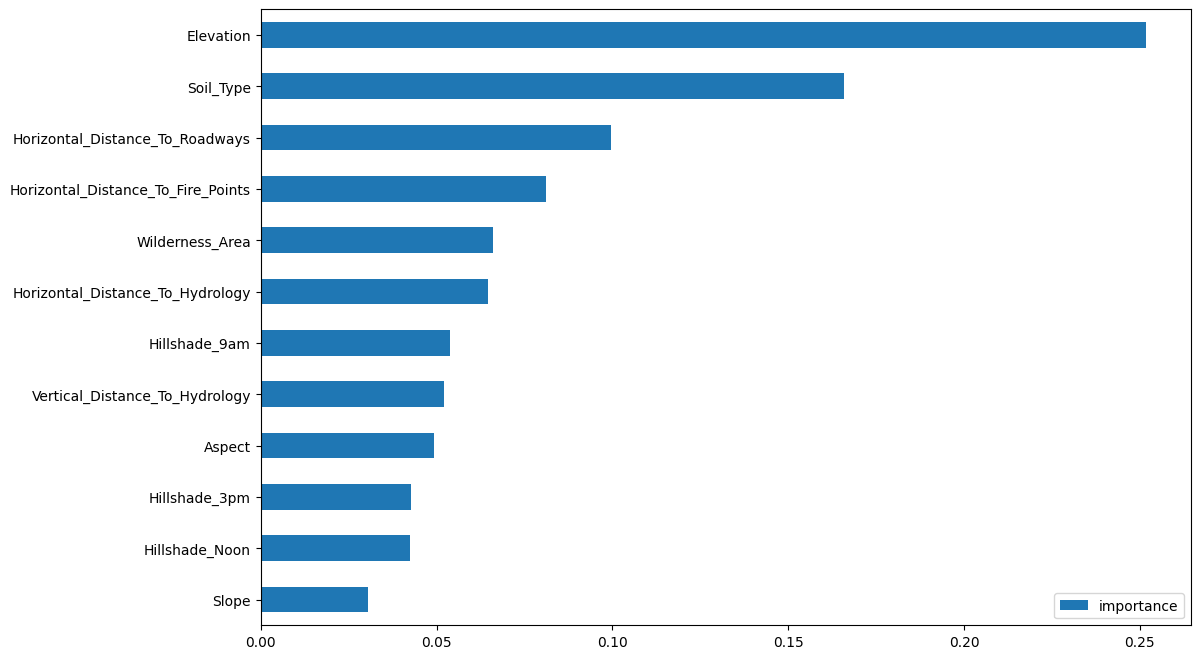

In [9]:
imp = pd.DataFrame(best_model.feature_importances_, index=X_train.columns, columns=['importance'])
print(imp.sort_values('importance')[::-1])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

Как видно из графика, признаки Elevation и Soil_Type являются наиболее влиятельными и их важность в предсказании составляет суммарно более 40%. 

Признаки Slope, Hillshade_Noon, Hillshade_3pm и Aspect являются самыми незначительными (менее 5% каждый). 
Это можно использовать для оптимизации модели, а именно уменьшению количества незначительных параметров или их объединение. 

Также данная модель уже была оптимизирована за счёт объединения бинарных признаков в один со значением номера, который описывает нужную характеристику. 

Данная модель может давать ошибки в случае низкого качества данных, отсутвия данных или выбросов. Данную проблему можно решить уже приведёнными в другом задании способами. 

Так же ошибки будут при неправильном вводе данных, при котором модель неправильно использует полученные данные и сделает гарантировано ошибку.

----------------

Оптимизация гиперпараметров при помощи Random Search

In [10]:


param_grid = {
    'n_estimators': range(300, 701, 100),
    'bootstrap': [True, False],
    'warm_start': [False, True],
    'max_features': ['sqrt', 'log2']+list(range(3, 9)),
    'min_samples_leaf': range(1, 8)
    
}

model = RandomForestClassifier(n_estimators=max_score_n, bootstrap=False,warm_start=True,random_state=1)

# Настройка RandomizedSearchCV

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=16, cv=5, scoring='accuracy', n_jobs=-1, 
                                   random_state=1)


# Обучение модели
random_search.fit(X_train, y_train)

# Лучшие гиперпараметры
print("Best HP:", random_search.best_params_)
print(f'Best accuracy: {random_search.best_score_:.4f}')
# Оценка на тестовой выборке
rs_best_model = random_search.best_estimator_
test_accuracy = rs_best_model.score(X_test, y_test)
print("Test accuracy:", test_accuracy)


Best HP: {'warm_start': False, 'n_estimators': 700, 'min_samples_leaf': 1, 'max_features': 5, 'bootstrap': False}
Best accuracy: 0.8648
Test accuracy: 0.8726851851851852


Данная настройка гиперпараметров показала, что параметр max_features и изменение его на значение 5 вместо стандартного sqrt может не значительно увеличить значение точности: с 0.871 до 0.873.

В остальном подобранные параметры примерно аналогичные. 

-----


Сохранение для использовании ее в API.

In [11]:
import joblib

# сохранение модели для дельнейшего использования
joblib.dump(best_model, 'data/model.pkl')

['data/model.pkl']